In [1]:
import os
import json
import glob
import gzip
import pickle
import mantel
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

# Invasive clusters exploration

In [2]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

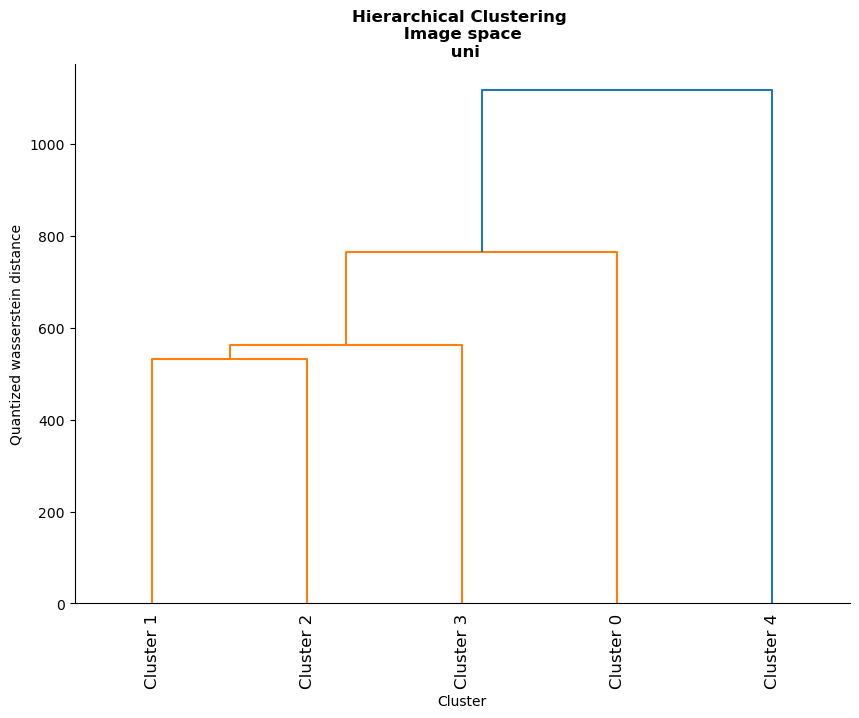

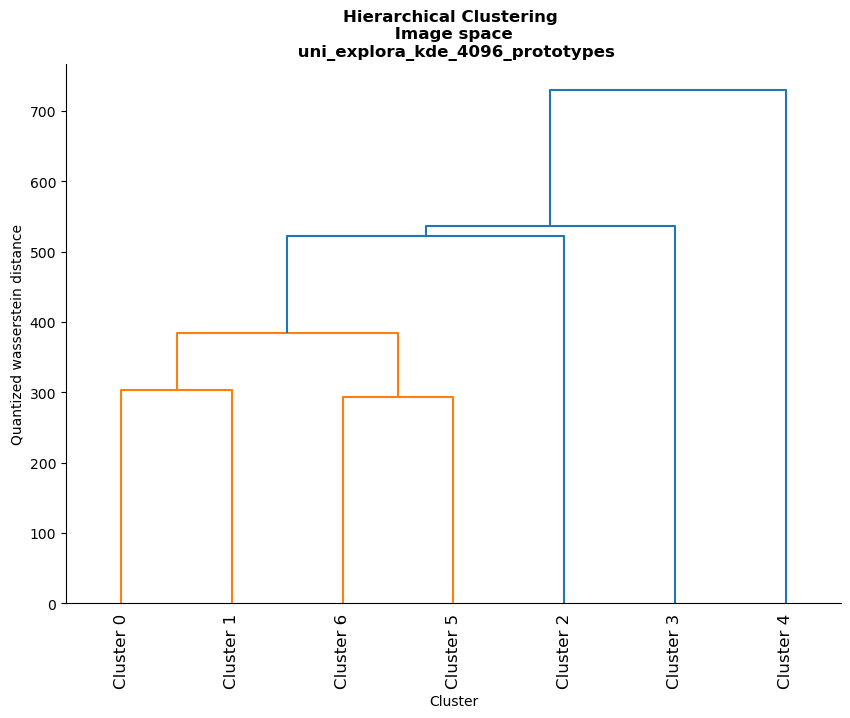

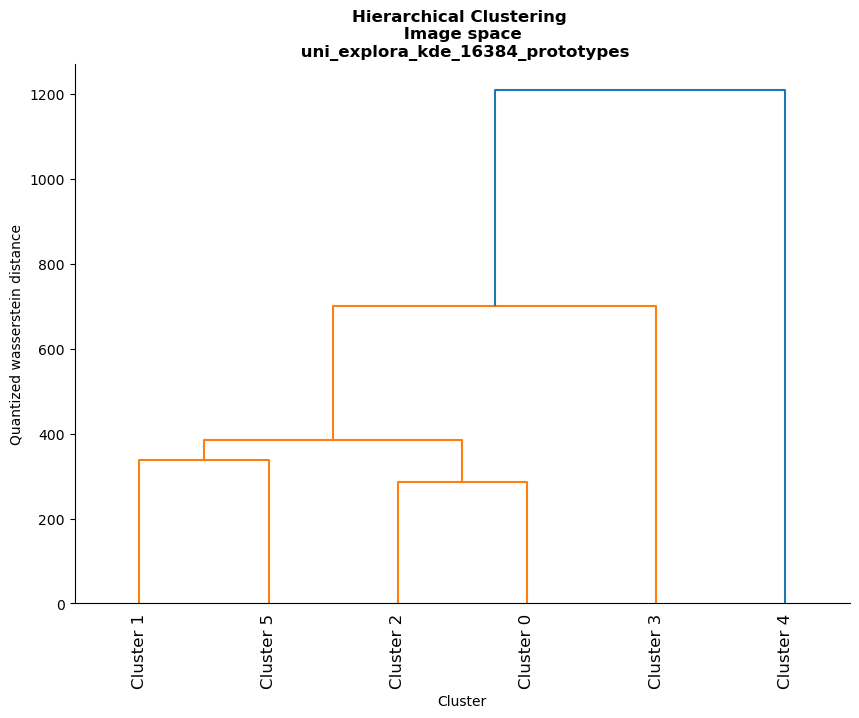

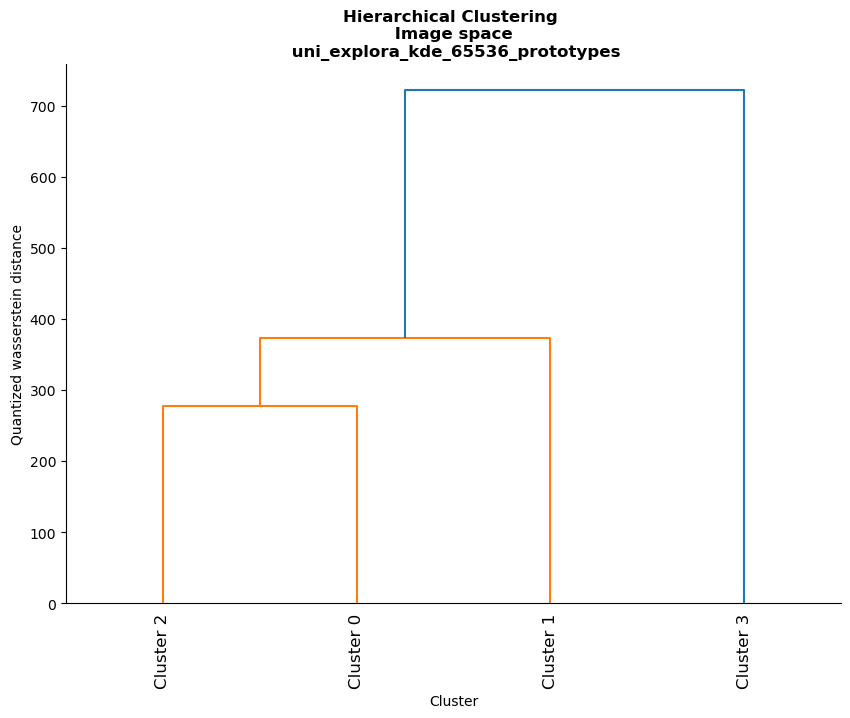

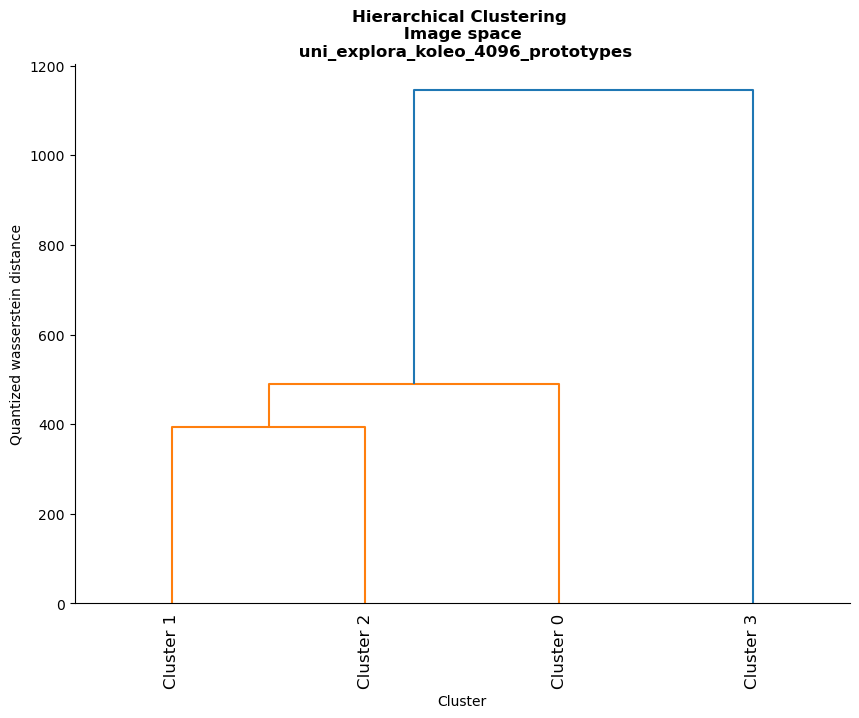

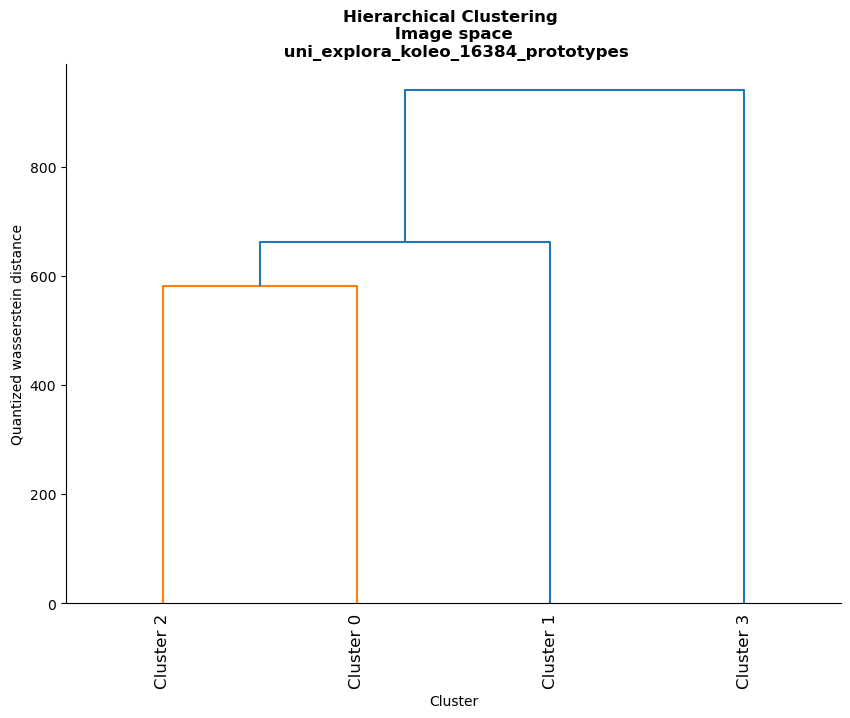

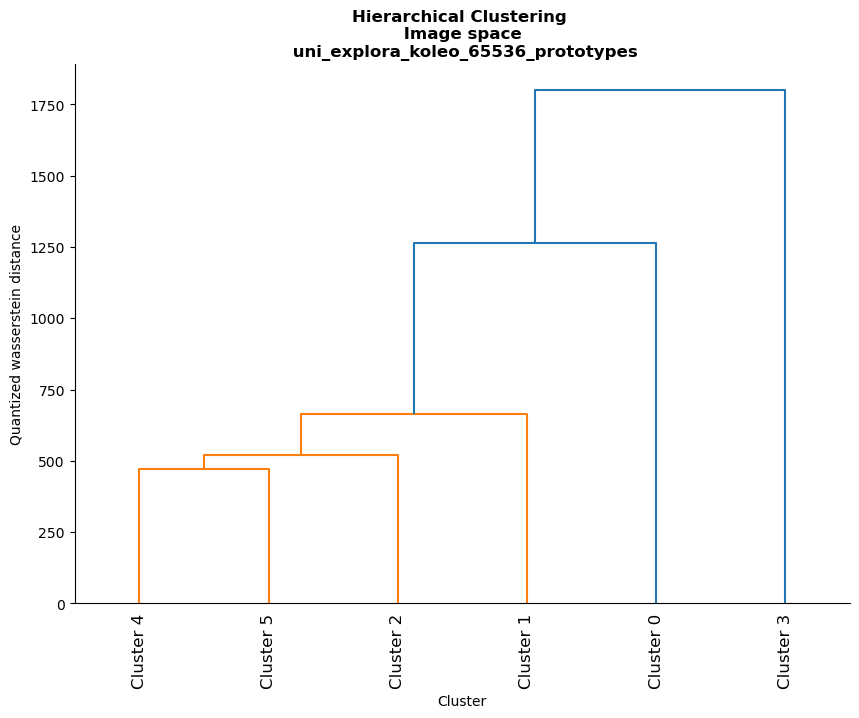

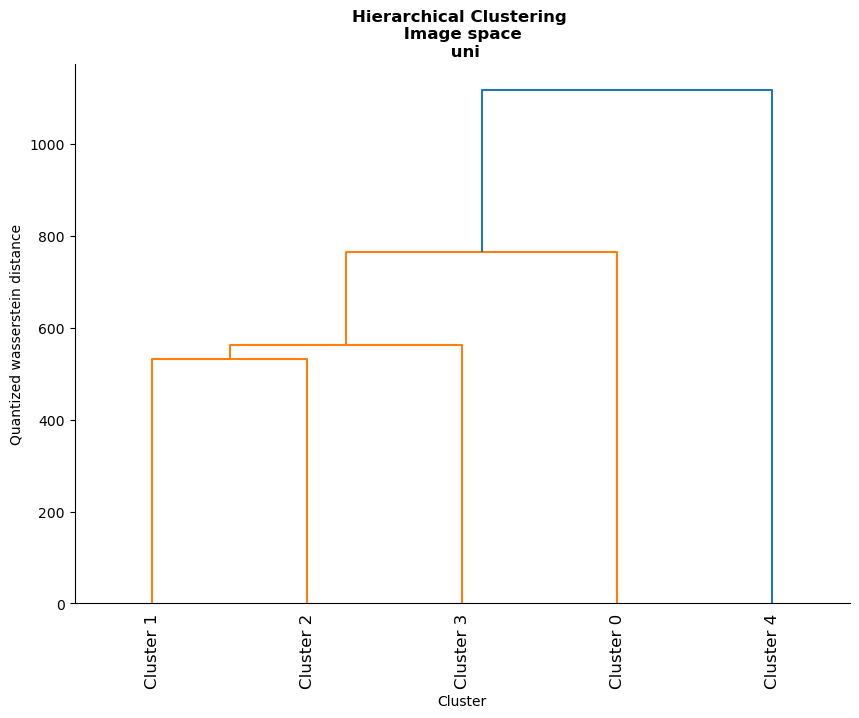

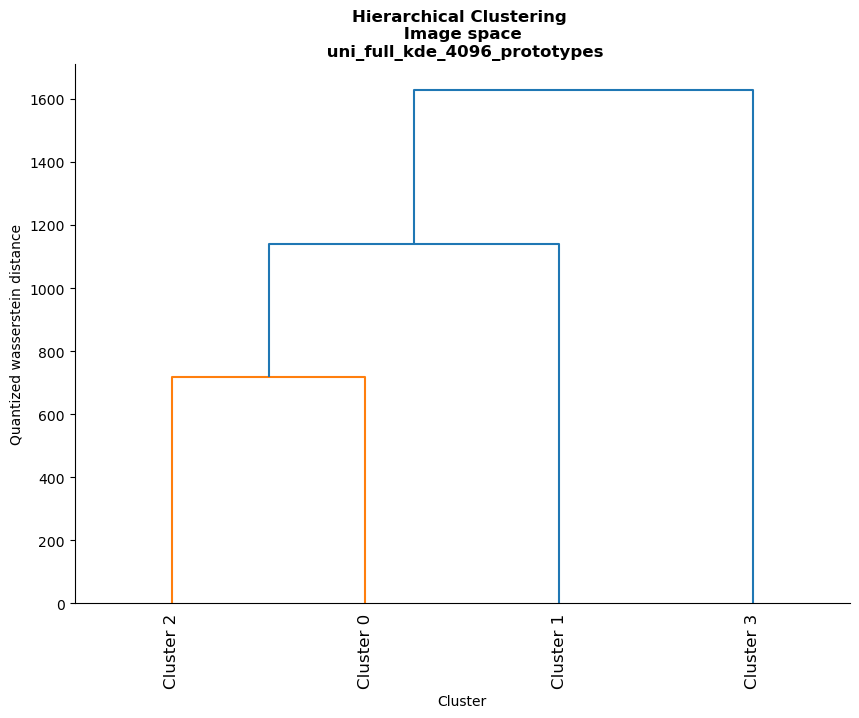

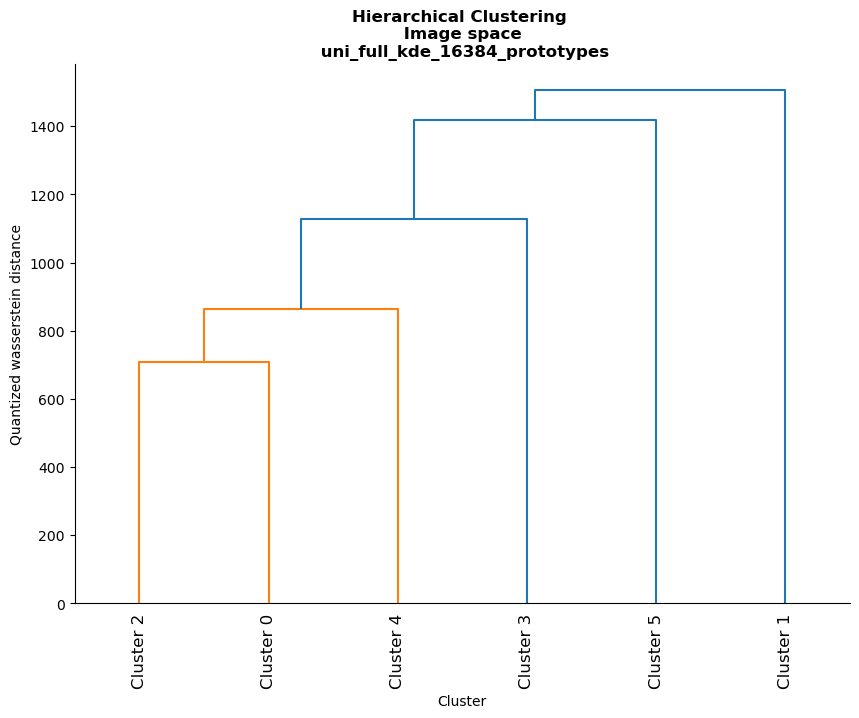

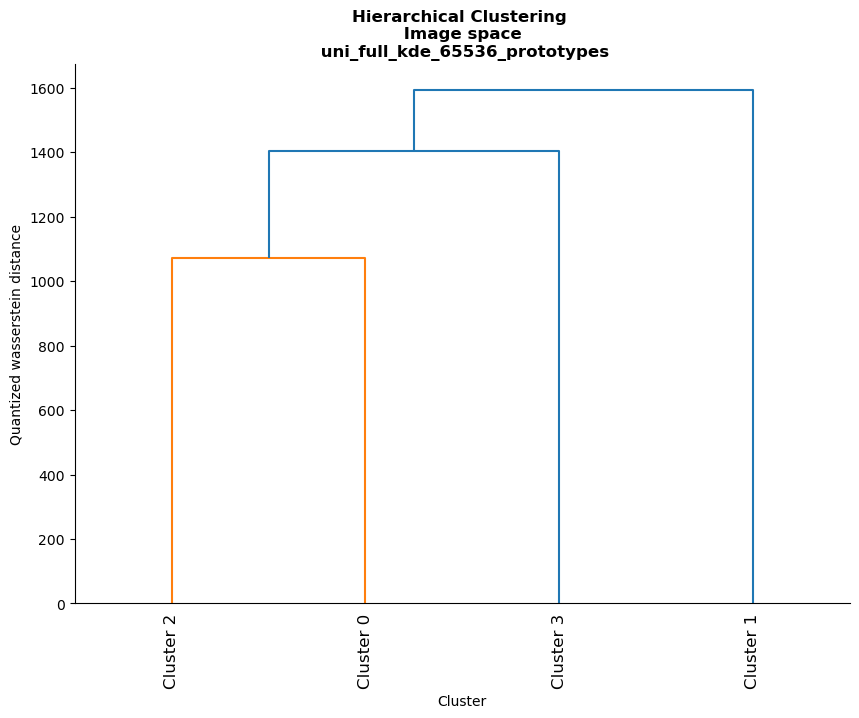

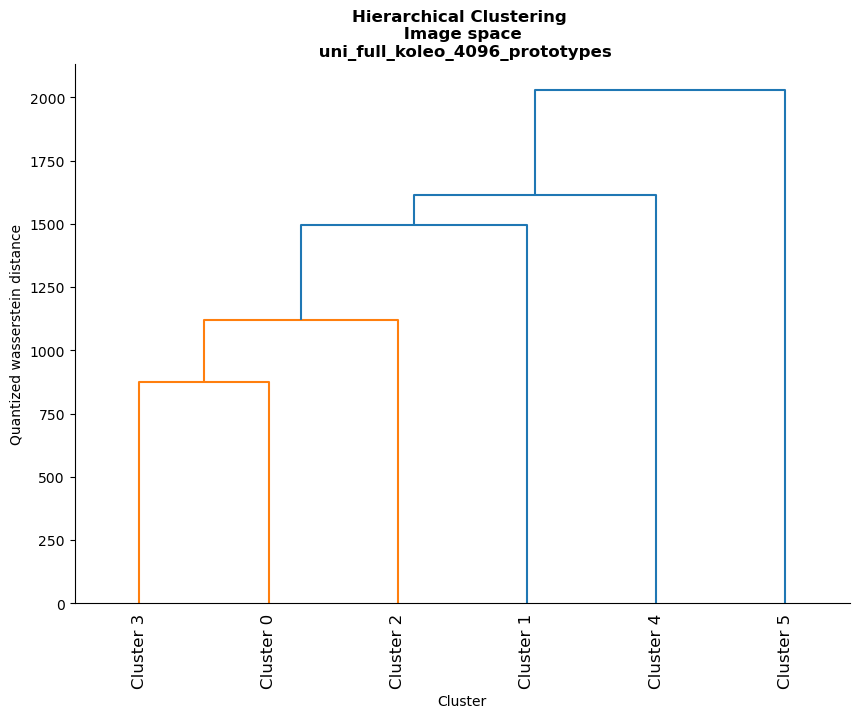

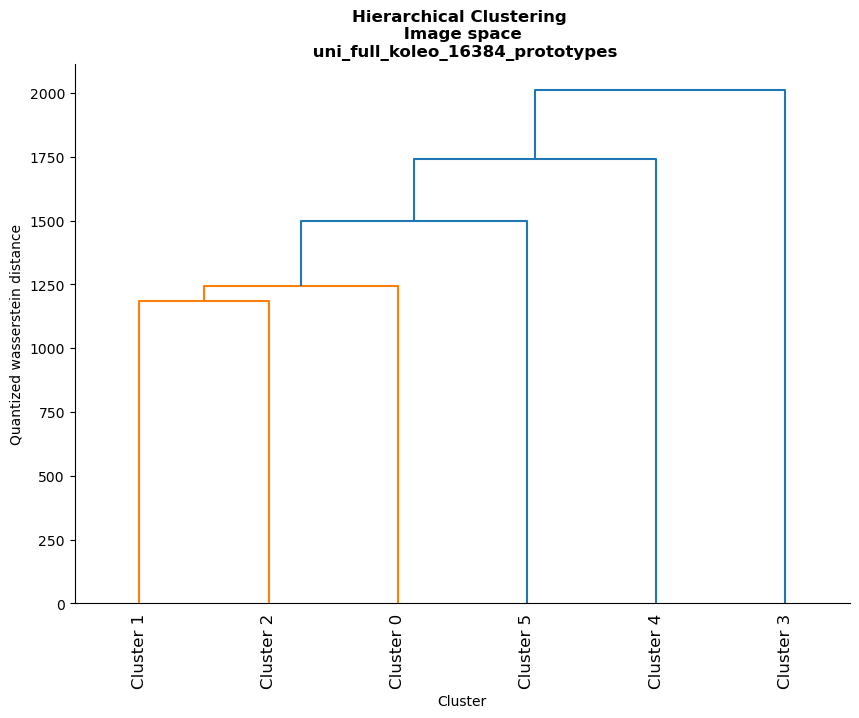

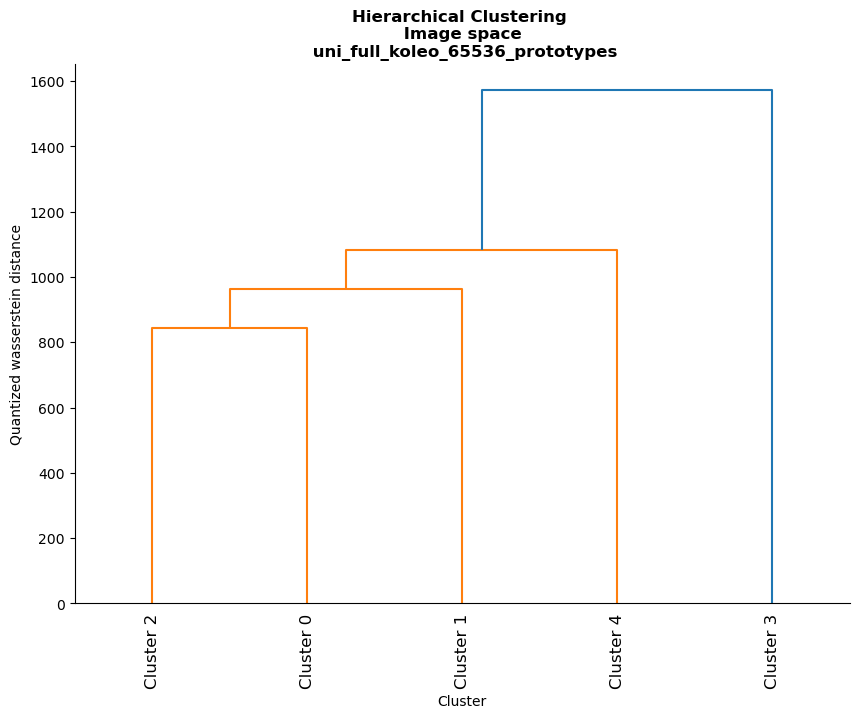

In [3]:
for model_type, names, benchmark_path in zip(
  [config['retrained_model_list1_type'], config['retrained_model_list2_type']],
  [config['retrained_model_list1'], config['retrained_model_list2']],
  [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):

  path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
  opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)

  for name in names:

        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        filenames = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, f"kmeans/{name}/quantized_wasserstein_distance_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv"))
        
        for filename in filenames:
            
            base_name = os.path.basename(filename)
            quantized_wasserstein = pd.read_csv(filename, index_col=0)
            quantized_wasserstein.columns = [f"Cluster {col}" for col in quantized_wasserstein.columns]
            quantized_wasserstein.index = [f"Cluster {idx}" for idx in quantized_wasserstein.index]

            # Perform hierarchical clustering
            linked = sch.linkage(squareform(quantized_wasserstein.values), method='complete')

            # Plot the dendrogram
            plt.figure(figsize=(10, 7))
            dendrogram = sch.dendrogram(linked, labels=quantized_wasserstein.columns, orientation='top', distance_sort='descending', show_leaf_counts=True)
            plt.title(f'Hierarchical Clustering \n Image space \n {name}', weight='bold')
            plt.xlabel('Cluster')
            plt.ylabel('Quantized wasserstein distance')
            plt.xticks(rotation=90)
            sns.despine()
            plt.savefig(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"dendrogram_{base_name.split('.csv')[0]}.pdf"), bbox_inches='tight')

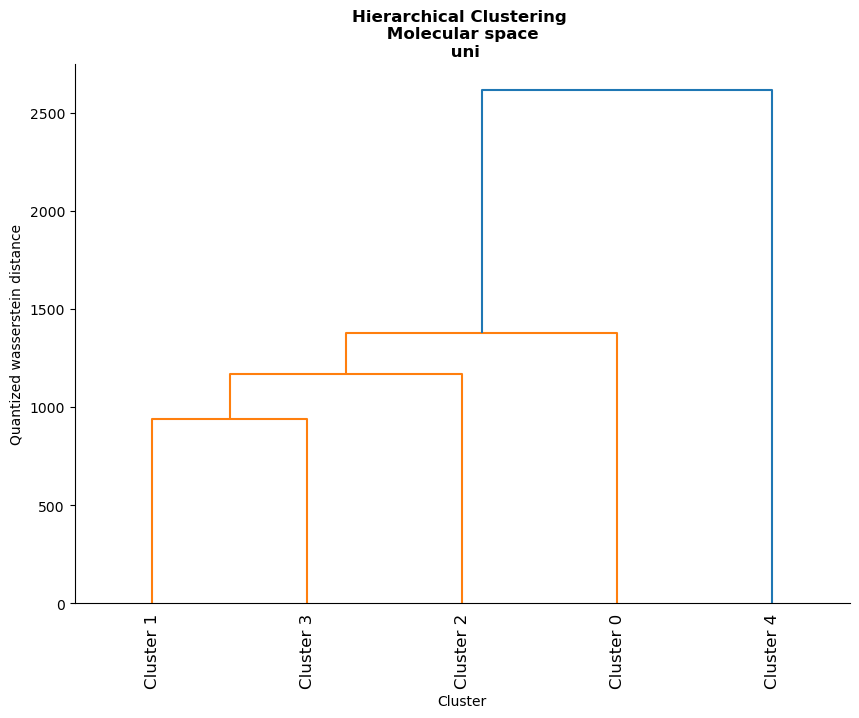

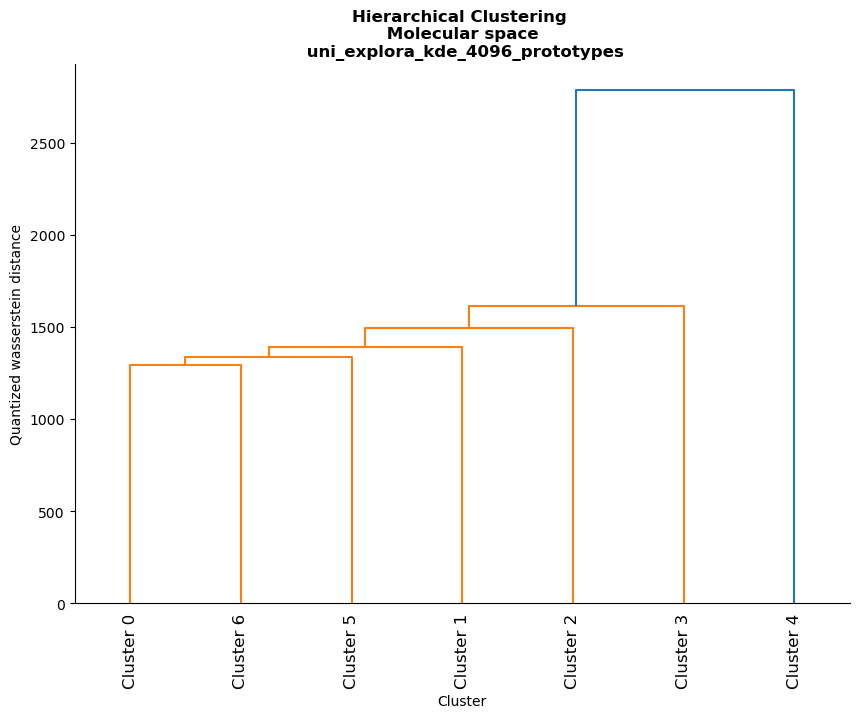

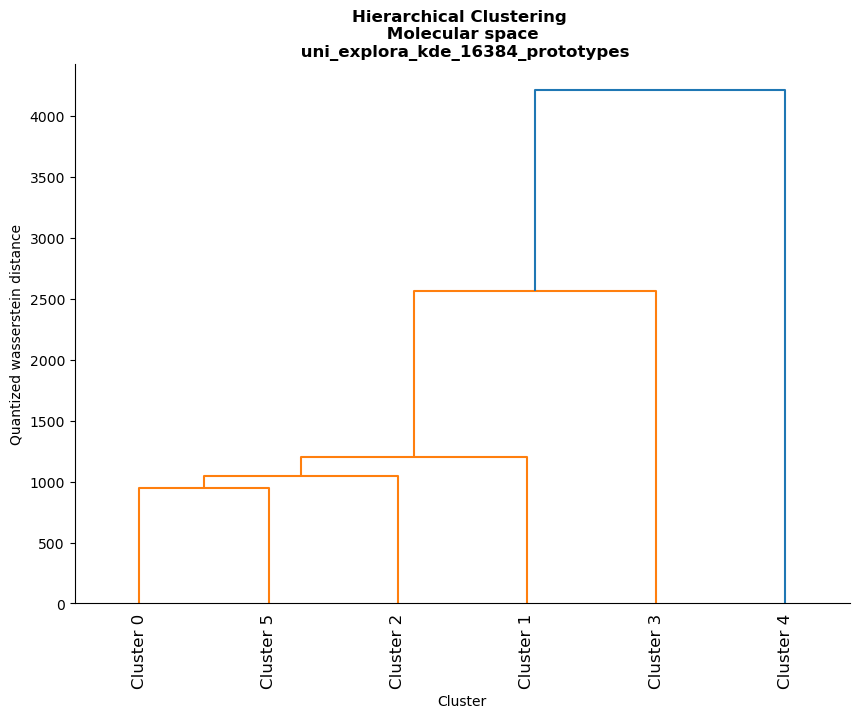

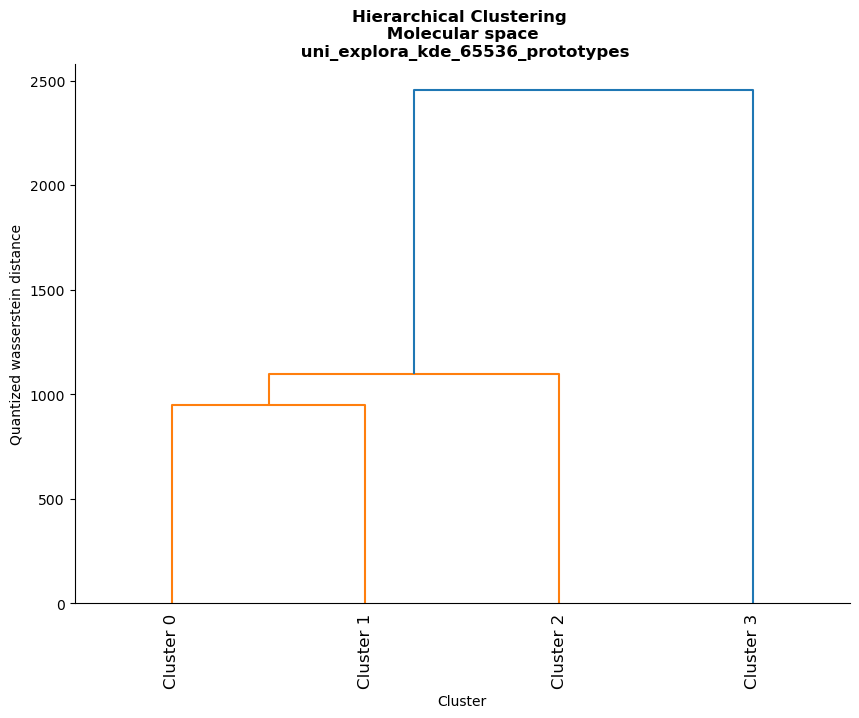

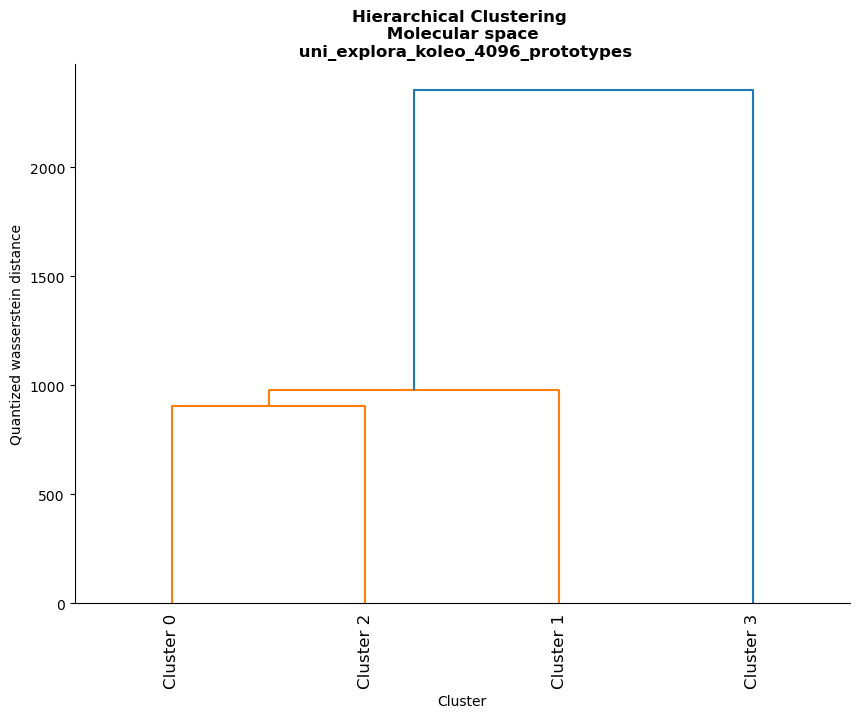

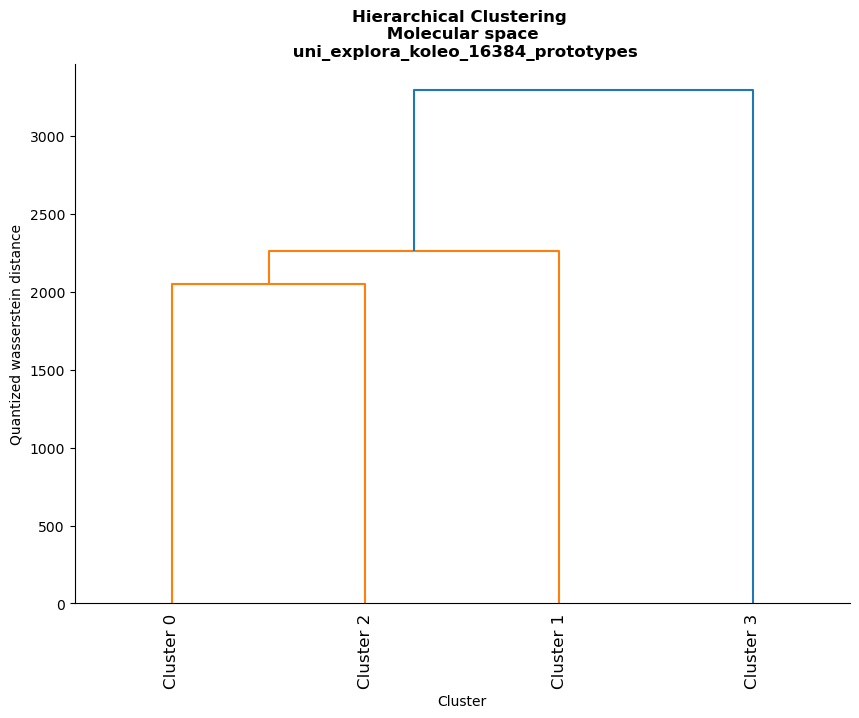

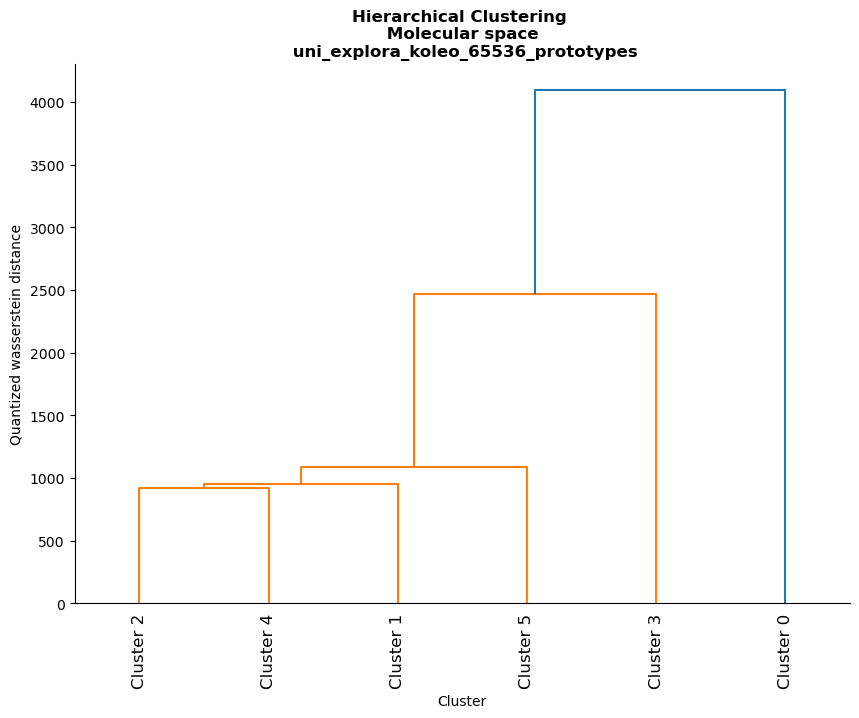

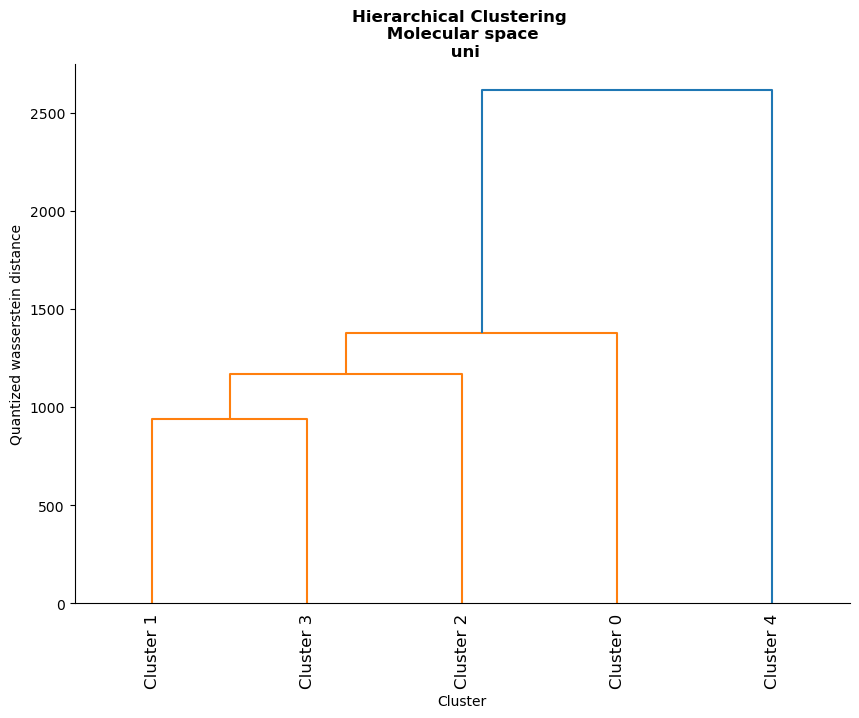

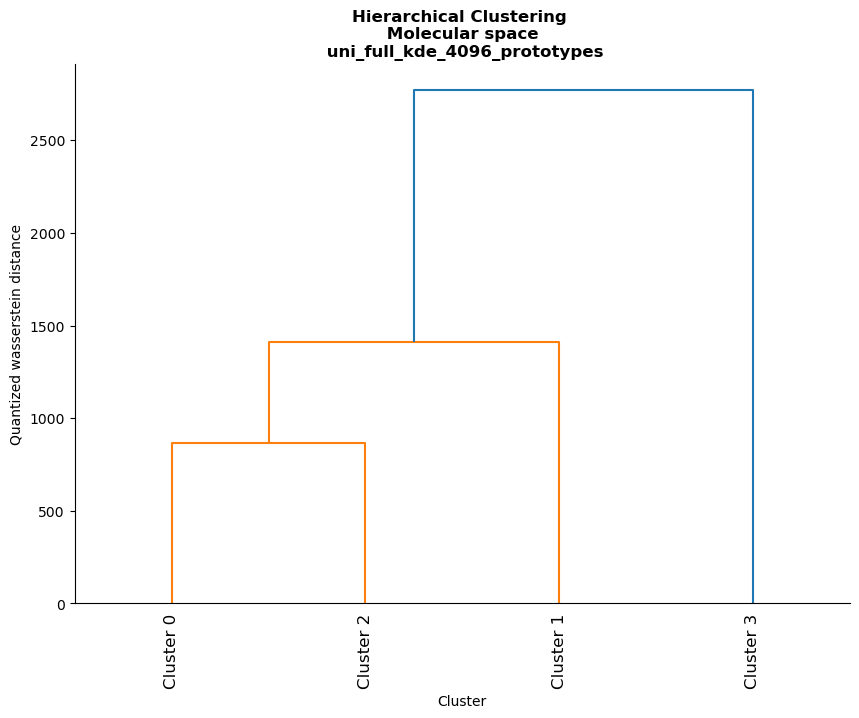

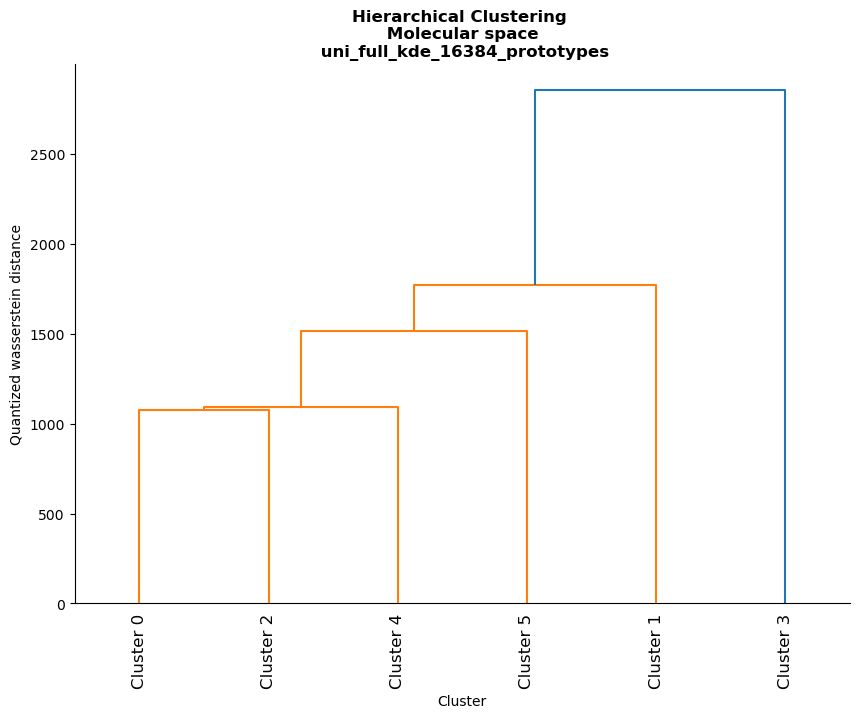

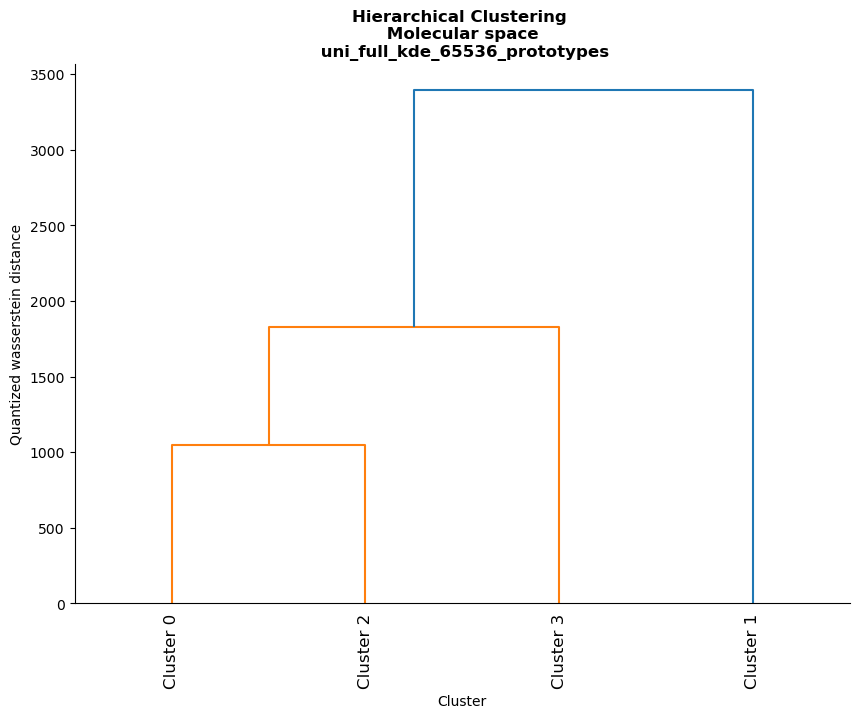

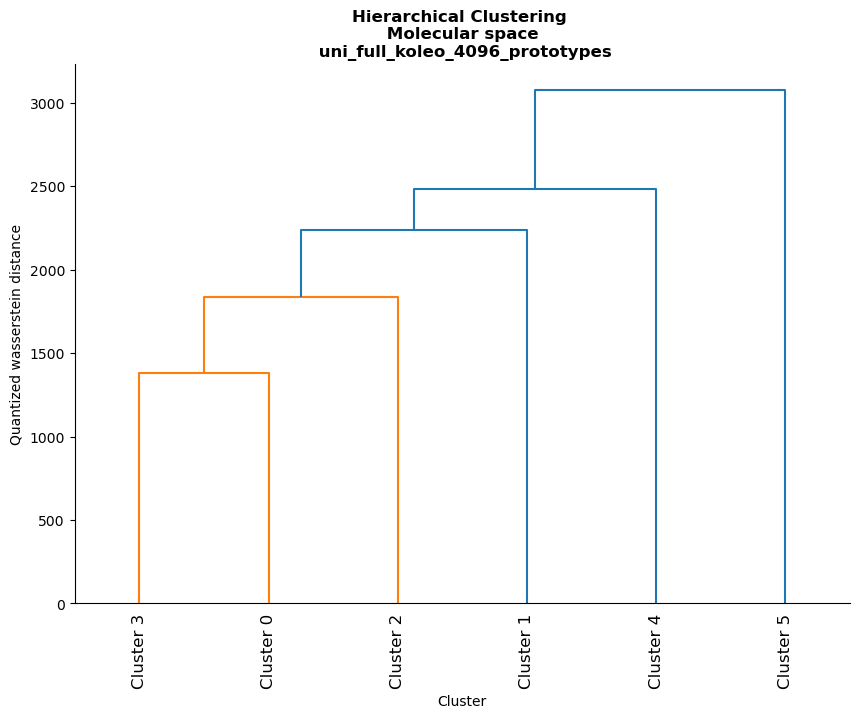

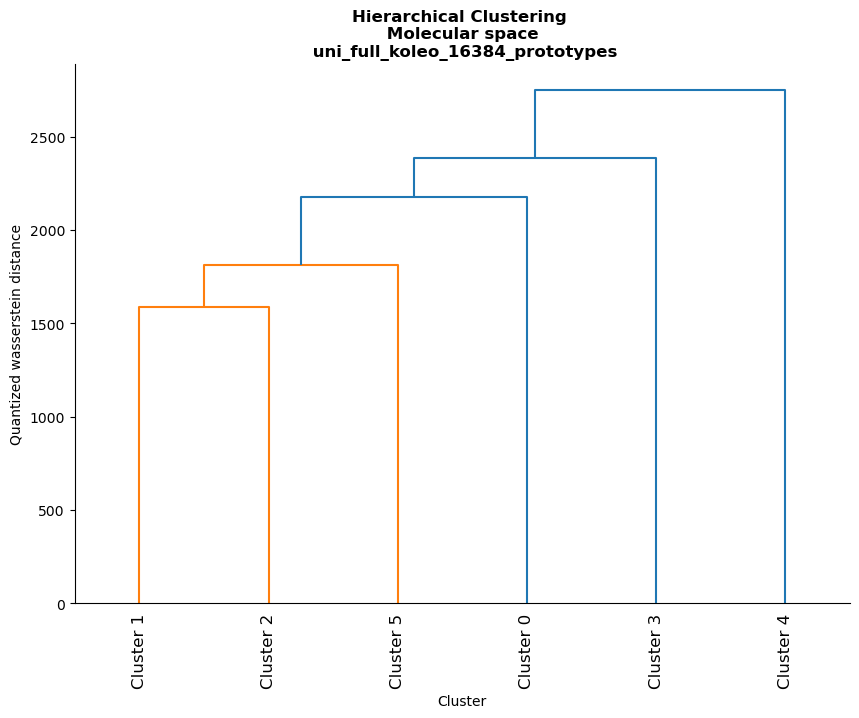

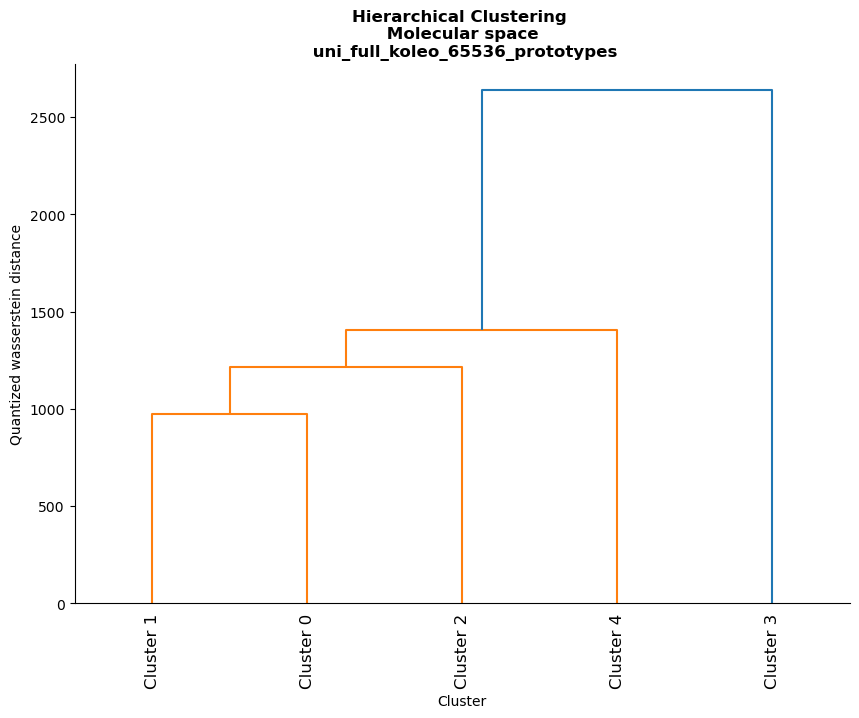

In [4]:
for model_type, names, benchmark_path in zip(
  [config['retrained_model_list1_type'], config['retrained_model_list2_type']],
  [config['retrained_model_list1'], config['retrained_model_list2']],
  [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):

  path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
  opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)

  for name in names:

        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        filenames = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, f"kmeans/{name}/quantized_wasserstein_distance_{name}_molecular_raw_filtered_normalized_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv"))
        
        for filename in filenames:
            
            base_name = os.path.basename(filename)
            quantized_wasserstein = pd.read_csv(filename, index_col=0)
            quantized_wasserstein.columns = [f"Cluster {col}" for col in quantized_wasserstein.columns]
            quantized_wasserstein.index = [f"Cluster {idx}" for idx in quantized_wasserstein.index]

            # Perform hierarchical clustering
            linked = sch.linkage(squareform(quantized_wasserstein), method='complete')

            # Plot the dendrogram
            plt.figure(figsize=(10, 7))
            dendrogram = sch.dendrogram(linked, labels=quantized_wasserstein.columns, orientation='top', distance_sort='descending', show_leaf_counts=True)
            plt.title(f'Hierarchical Clustering \n Molecular space \n {name}', weight='bold')
            plt.xlabel('Cluster')
            plt.ylabel('Quantized wasserstein distance')
            plt.xticks(rotation=90)
            sns.despine()
            plt.savefig(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"dendrogram_molecular_{base_name.split('.csv')[0]}.pdf"), bbox_inches='tight')

In [5]:
results_mantel = {}

for model_type, names, benchmark_path in zip(
    [config['retrained_model_list1_type'], config['retrained_model_list2_type']],
    [config['retrained_model_list1'], config['retrained_model_list2']],
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):

    path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
    optimal_cluster_numbers = opti_clusters.loc[names, 'n_clusters'].values

    for name, cluster_number in zip(names, optimal_cluster_numbers):
        
        results_mantel[name] = {}
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
        cluster_number = opti_clusters.loc[name, 'n_clusters']
        patients_files = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{cluster_number}_clusters_patient_*.csv"))
        patients = [os.path.basename(f).split(f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{cluster_number}_clusters_patient_")[1].split(".csv")[0] for f in patients_files]
        patients = list(set(patients))

        mantel_correlations = []
        for i in range(len(patients)):
            for j in range(i+1, len(patients)):
                distance_matrix1 = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{cluster_number}_clusters_patient_{patients[i]}.csv"), index_col=0)
                distance_matrix2 = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{cluster_number}_clusters_patient_{patients[j]}.csv"), index_col=0)
                    
                # Find the common clusters
                common_clusters = list(set(distance_matrix1.index).intersection(set(distance_matrix2.index)))
                distance_matrix1 = distance_matrix1.loc[common_clusters][[str(cluster) for cluster in common_clusters]]
                distance_matrix2 = distance_matrix2.loc[common_clusters][[str(cluster) for cluster in common_clusters]]
                print(f"Common clusters between {patients[i]} and {patients[j]}: {common_clusters}")

                if distance_matrix1.shape[0] > 2 or distance_matrix2.shape[0] > 2:
                    mantel_corr = mantel.test(distance_matrix1.values, distance_matrix2.values, perms=1000, method='pearson', tail='upper')
                    mantel_correlations.append(mantel_corr.r)
                    
        results_mantel[name] = mantel_correlations

Common clusters between TNBC13 and TNBC24: []
Common clusters between TNBC13 and TNBC9: [2]
Common clusters between TNBC13 and TNBC6: [2]
Common clusters between TNBC13 and TNBC50: [2]
Common clusters between TNBC13 and TNBC73: [2]
Common clusters between TNBC13 and TNBC93: [2]
Common clusters between TNBC13 and TNBC1: [2]
Common clusters between TNBC13 and TNBC5: [2]
Common clusters between TNBC13 and TNBC52: [2]
Common clusters between TNBC13 and TNBC36: [2]
Common clusters between TNBC13 and TNBC74: [2]
Common clusters between TNBC13 and TNBC53: [2]
Common clusters between TNBC13 and TNBC94: [2]
Common clusters between TNBC13 and TNBC59: [2]
Common clusters between TNBC13 and TNBC69: [2]
Common clusters between TNBC13 and TNBC65: [2]
Common clusters between TNBC13 and TNBC31: [2]
Common clusters between TNBC13 and TNBC27: [2]
Common clusters between TNBC13 and TNBC19: [2]
Common clusters between TNBC13 and TNBC60: [2]
Common clusters between TNBC13 and TNBC46: [2]
Common clusters be

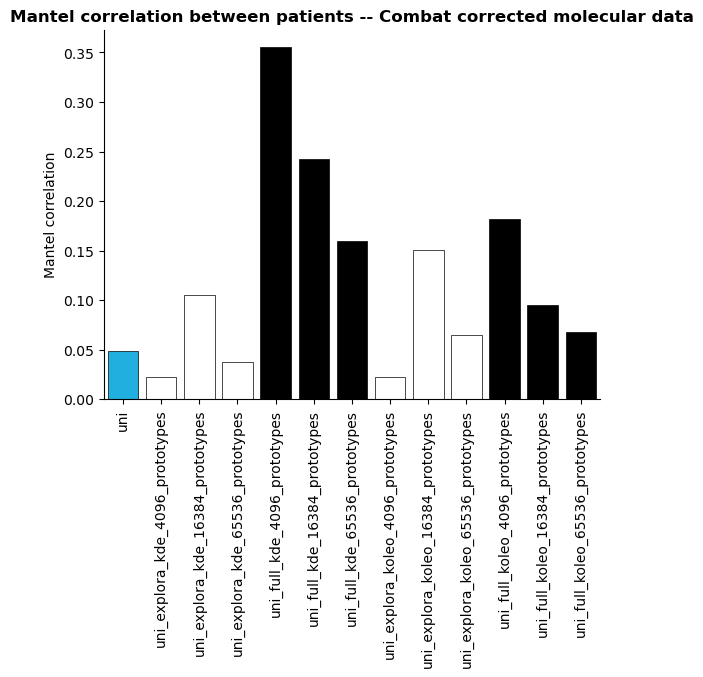

In [6]:
df = pd.DataFrame.from_dict(results_mantel, orient='index').T[[
  "uni",
  "uni_explora_kde_4096_prototypes", "uni_explora_kde_16384_prototypes", "uni_explora_kde_65536_prototypes",
  "uni_full_kde_4096_prototypes", "uni_full_kde_16384_prototypes", "uni_full_kde_65536_prototypes",
  "uni_explora_koleo_4096_prototypes", "uni_explora_koleo_16384_prototypes", "uni_explora_koleo_65536_prototypes",
  "uni_full_koleo_4096_prototypes", "uni_full_koleo_16384_prototypes", "uni_full_koleo_65536_prototypes"]]

palette=["deepskyblue", "white", "white", "white", "black", "black", "black", 
         "white", "white", "white", "black", "black", "black"]

sns.barplot(df, palette=palette, linewidth=0.5, edgecolor="black", errorbar=None)

plt.xticks(rotation=90)
sns.despine()
plt.title("Mantel correlation between patients -- Combat corrected molecular data", weight='bold')
plt.ylabel("Mantel correlation")

plt.savefig(os.path.join(config['figures_folder'], "Figure4", "mantel_correlation_dendrogram_patients_raw_filtered_normalized_data.pdf"), bbox_inches='tight')